# Проект: классификация

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import math
from textwrap import wrap
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [320]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [321]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
print(df.balance.isna().sum())
df.info()

25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [322]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Специальное слово - **unknown**

### Задание 3

In [323]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Удаляем $, пробелы, заменяем запятую на точку, убираем .00
df['balance'] = (df['balance']
                 .str.replace(r'[$\s]', '', regex=True)  # Удаляем $ и пробелы
                 .str.replace(',', '.')                  # Заменяем запятую на точку
                 .astype(float)                          # Преобразуем в float
                 .round(0))                              # Убираем десятичные нули (2343.00 → 2343.0)

### Задание 4

In [324]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
median_balance = df['balance'].median()
# Заменяем пропуски на медиану
df['balance'] = df['balance'].fillna(median_balance)

### Задание 5

In [325]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# Замена 'unknown' на моду в признаке job
job_mode = df['job'].value_counts().idxmax()
df['job'] = df['job'].replace('unknown', job_mode)

# Замена 'unknown' на моду в признаке education
education_mode = df['education'].value_counts().idxmax()
df['education'] = df['education'].replace('unknown', education_mode)

### Задание 6

In [326]:
# Рассчитываем квартили

Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Вычисляем границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Округляем до целых чисел
lower_bound = int(round(lower_bound))
upper_bound = int(round(upper_bound))

print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")

Нижняя граница: -2241
Верхняя граница: 4063


In [327]:
# удалите все выбросы для признака balance
# ваш код
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

Имеют депозит: 

 4681
Не имеют депозит:  5424


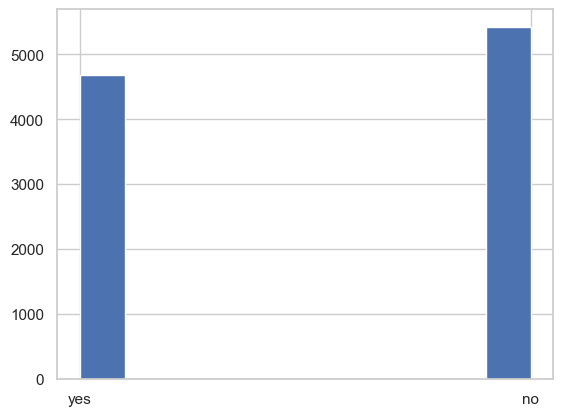

In [328]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df['deposit'].hist()
print('Имеют депозит: ', sum(df['deposit'] == 'yes'))
print('Не имеют депозит: ',sum(df['deposit'] == 'no'))

### Задания 2 и 3

In [329]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


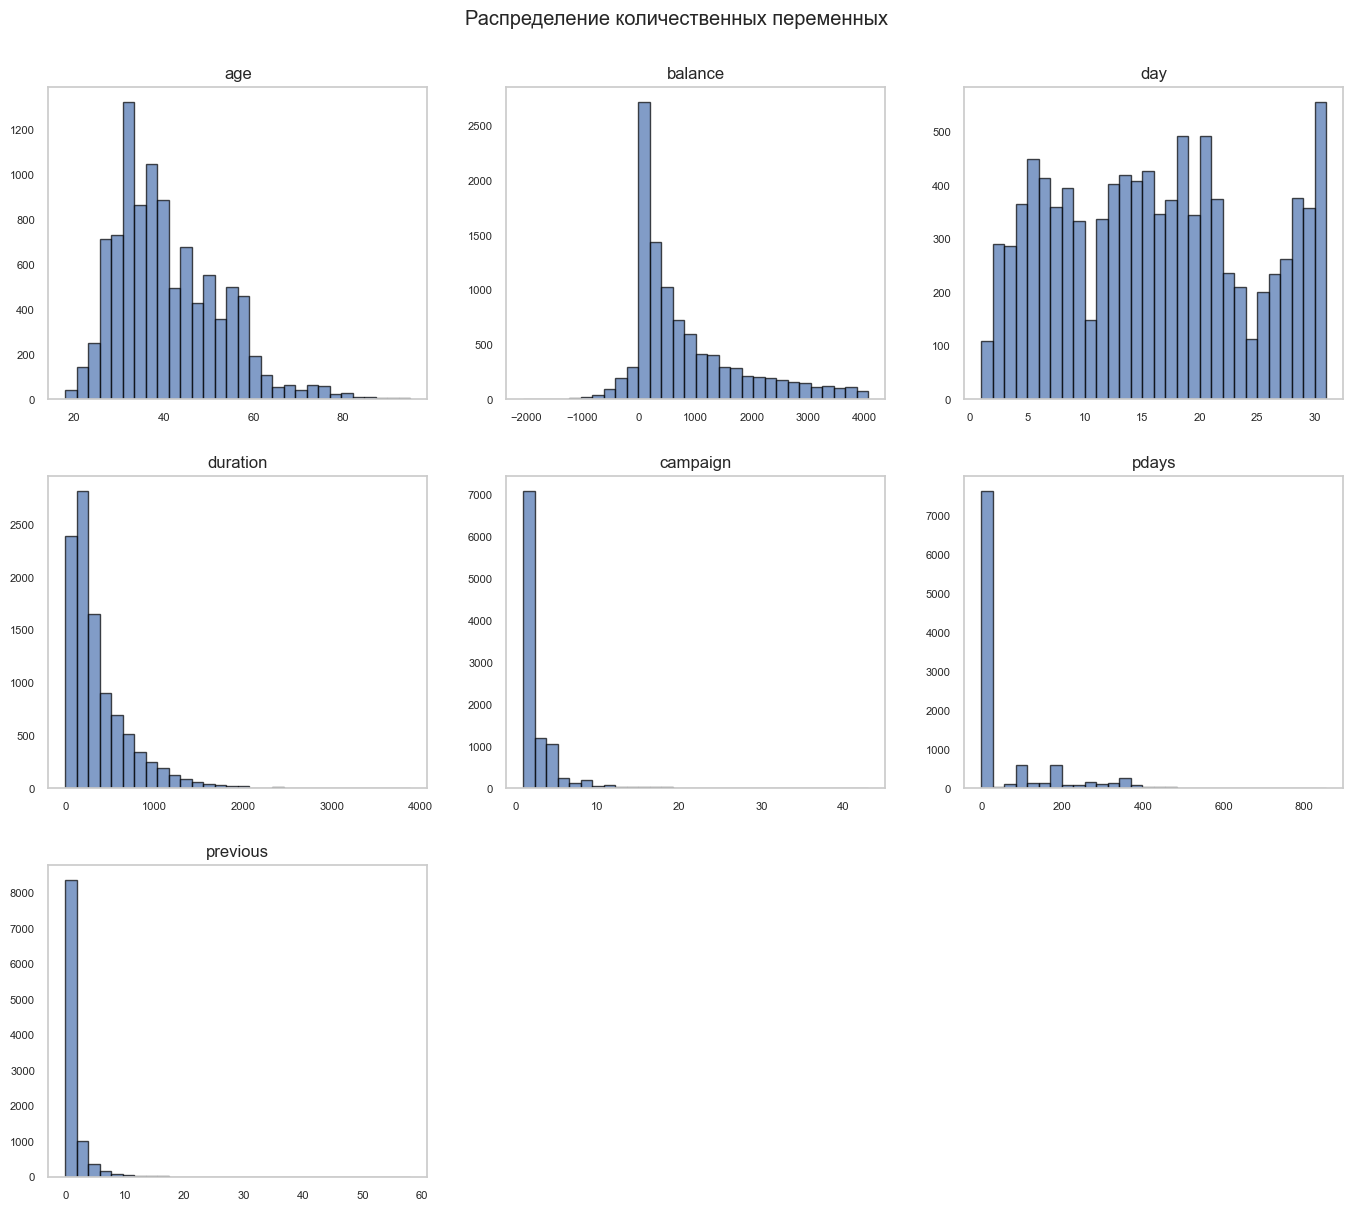

In [330]:
# Определяем количество графиков
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / 3)  # 3 столбца, строки вычисляем автоматически

# Строим гистограммы с динамическим layout
df[numeric_cols].hist(
    bins=30,
    figsize=(14, 4*n_rows),  # Динамическая высота в зависимости от количества строк
    layout=(n_rows, 3),      # 3 столбца, строки вычислены выше
    xlabelsize=8,
    ylabelsize=8,
    grid=False,
    edgecolor='black',
    alpha=0.7
)

plt.tight_layout(pad=2.0)
plt.suptitle('Распределение количественных переменных', y=1.02)
plt.show()

### Задания 4 и 5

In [331]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


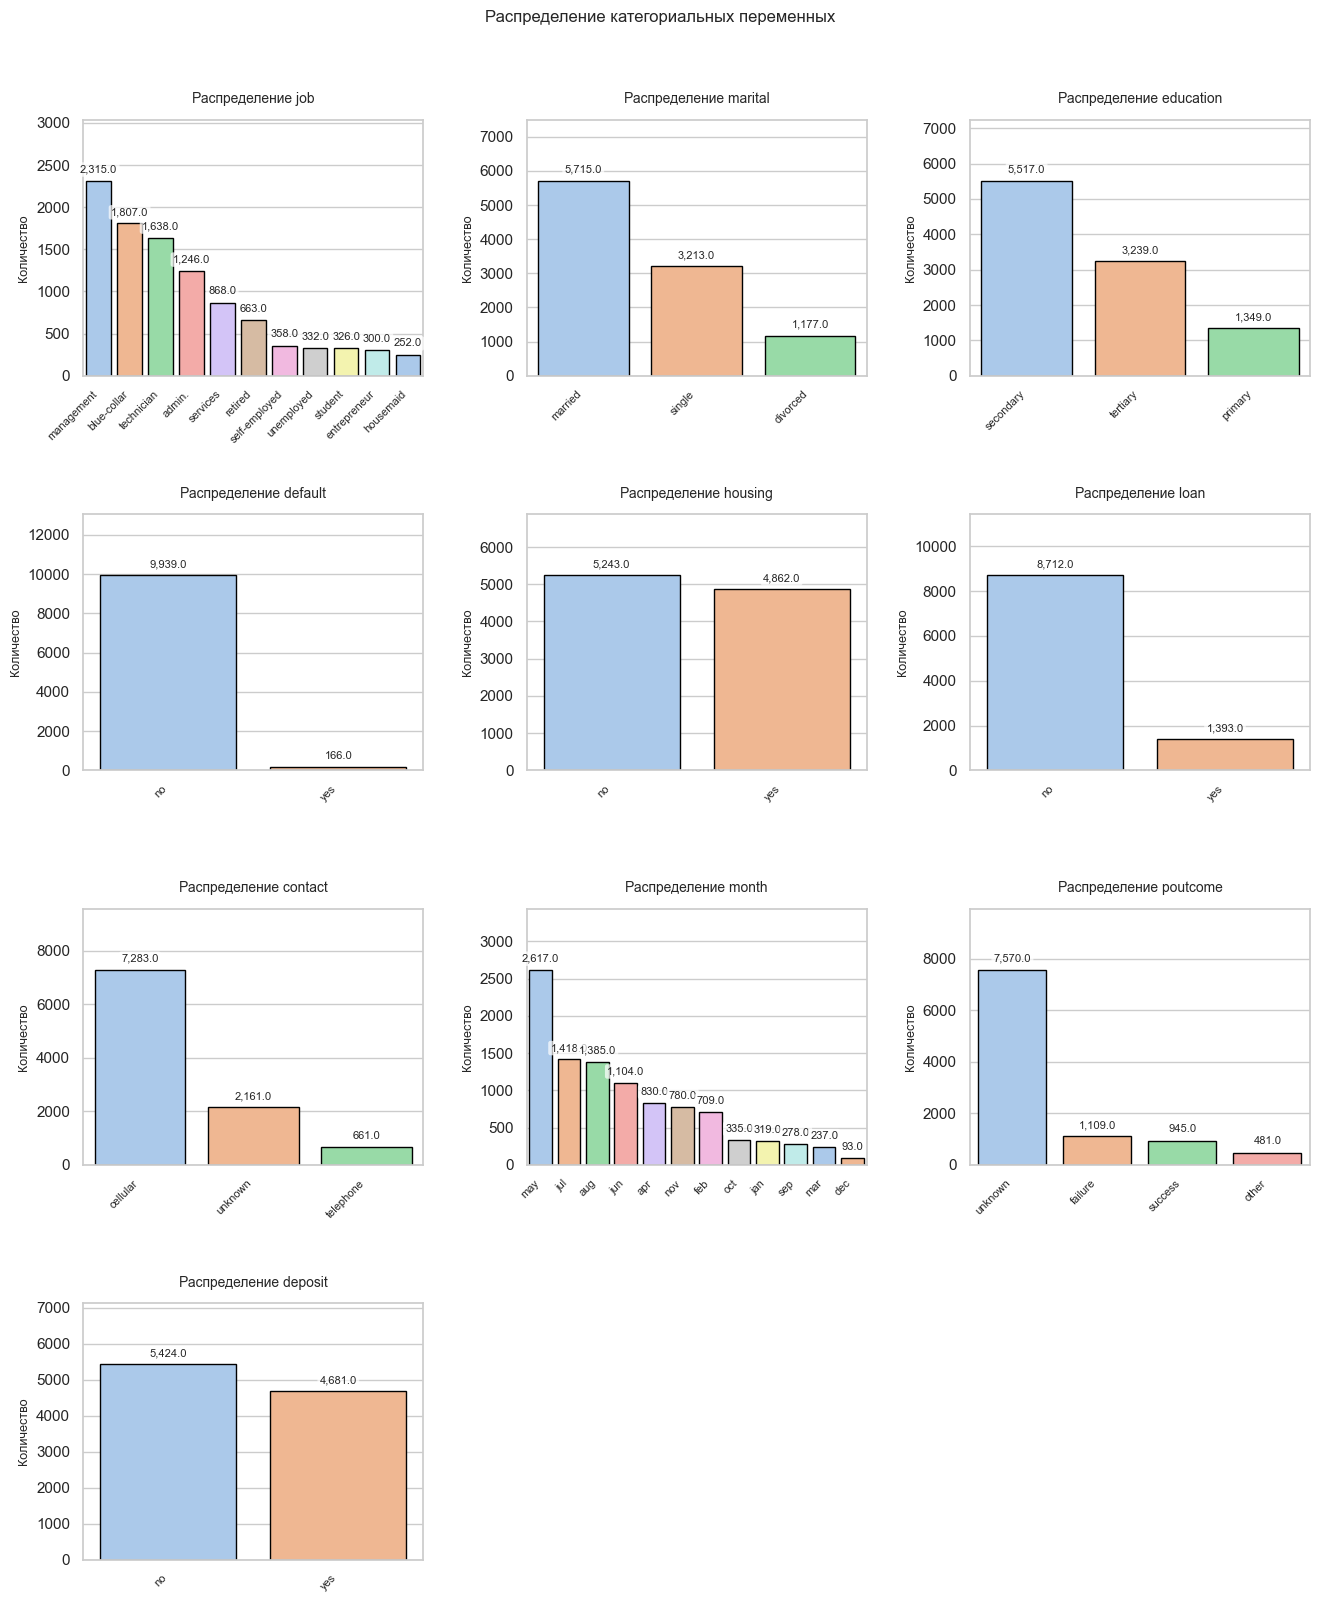

In [332]:
# Определяем параметры сетки
n_cols = len(cat_cols)
n_rows = math.ceil(n_cols / 3)

# Настраиваем размер фигуры с учетом количества категорий
max_cats = max([df[col].nunique() for col in cat_cols])
fig_height = max(4*n_rows, 0.5*max_cats)  # Динамическая высота

plt.figure(figsize=(14, fig_height))

# Строим графики
for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, 3, i)
    
    # Подготовка данных
    value_counts = df[col].value_counts()
    order = value_counts.index
    
    # Перенос длинных названий (макс 15 символов на строку)
    labels = ['\n'.join(wrap(str(x), 15)) for x in order]
    
    # Создаем график
    ax = sns.countplot(data=df, x=col, order=order, palette='pastel', edgecolor='black')
    
    # Настройки осей
    plt.title(f'Распределение {col}', pad=12, fontsize=10)
    plt.xticks(range(len(order)), labels, rotation=45, ha='right', fontsize=8)
    plt.xlabel('')
    plt.ylabel('Количество', fontsize=9)
    
    # Автоматическая настройка Y-оси
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max * 1.25)
    
    # Умные аннотации
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., 
                height + (y_max * 0.03),
                f'{height:,}',
                ha='center', 
                va='bottom',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', 
                         fc='white', 
                         ec='none', 
                         alpha=0.7))

# Оптимальные отступы
plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=1.8)
plt.suptitle('Распределение категориальных переменных', y=1.02, fontsize=12)
plt.show()

### Задание 6

Статусы предыдущей кампании с преобладанием успехов в текущей:
['other', 'success']


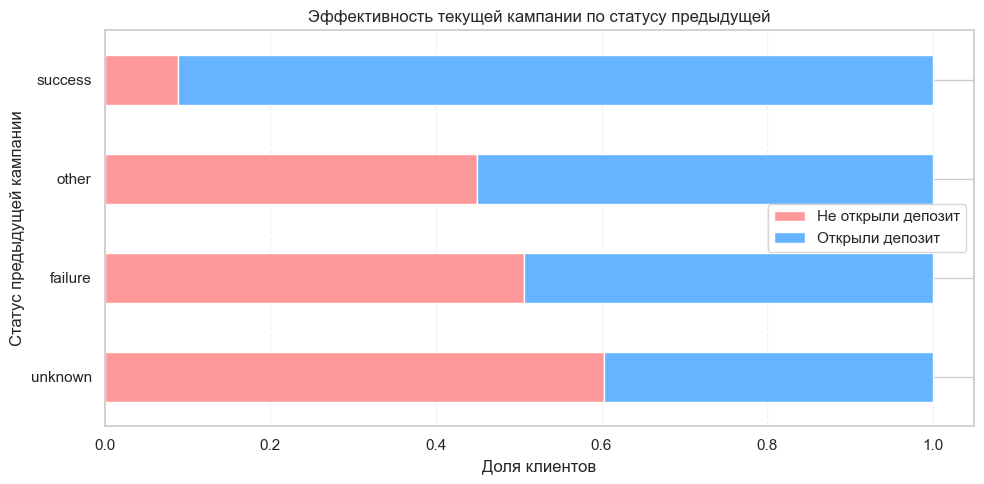

In [333]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# 1. Группируем по статусу предыдущей кампании и анализируем результат текущей (deposit)
result = (df.groupby('poutcome')['deposit']
          .value_counts(normalize=True)
          .unstack()
          .fillna(0))

# 2. Находим статусы, где успехов ('yes') больше, чем неудач ('no')
successful_statuses = result[result['yes'] > result['no']].index.tolist()

print("Статусы предыдущей кампании с преобладанием успехов в текущей:")
print(successful_statuses)

# 3. Визуализация
result[['no', 'yes']].sort_values('yes').plot(
    kind='barh', 
    stacked=True, 
    color=['#ff9999', '#66b3ff'],
    figsize=(10, 5)
)
plt.title('Эффективность текущей кампании по статусу предыдущей')
plt.xlabel('Доля клиентов')
plt.ylabel('Статус предыдущей кампании')
plt.legend(['Не открыли депозит', 'Открыли депозит'])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Задание 7

Самый неудачный месяц: may (67.86% неудач)


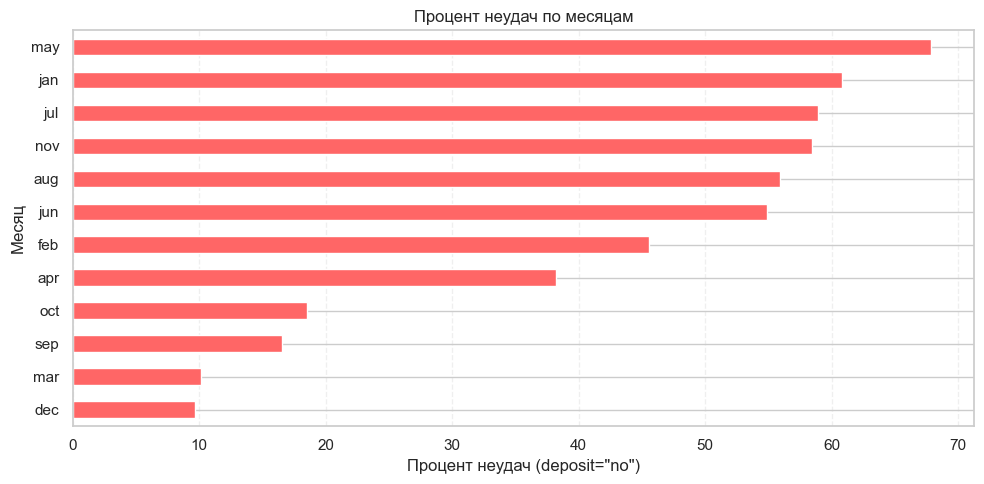

In [334]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Рассчитываем процент неудач по месяцам
monthly_failure = (df[df['deposit'] == 'no'].groupby('month')['deposit'].count() / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)

# Находим месяц с максимальным процентом неудач
worst_month = monthly_failure.idxmax()
worst_percentage = monthly_failure.max()

print(f'Самый неудачный месяц: {worst_month} ({worst_percentage:.2f}% неудач)')

# Визуализация
plt.figure(figsize=(10, 5))
monthly_failure.sort_values().plot(kind='barh', color='#ff6666')
plt.title('Процент неудач по месяцам')
plt.xlabel('Процент неудач (deposit="no")')
plt.ylabel('Месяц')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Задание 8

<Figure size 1000x600 with 0 Axes>

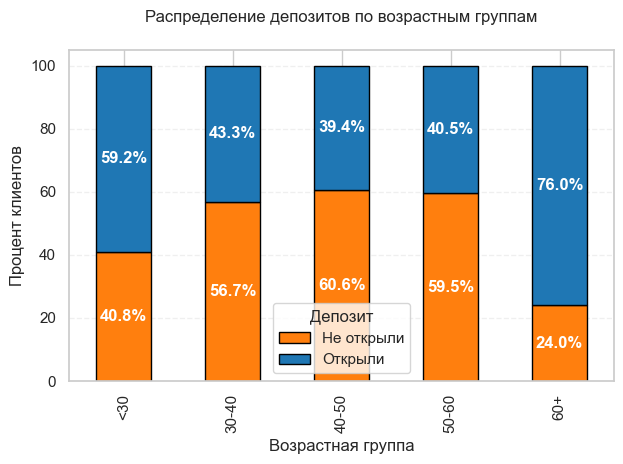

In [335]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# 1. Создаем возрастные группы
bins = [0, 30, 40, 50, 60, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# 2. Анализируем распределение депозитов по возрастным группам
deposit_by_age = df.groupby(['age_group', 'deposit']).size().unstack()

# 3. Нормализуем данные для сравнения долей
deposit_percent = deposit_by_age.div(deposit_by_age.sum(axis=1), axis=0) * 100

# 4. Визуализация (Stacked Bar Chart)
plt.figure(figsize=(10, 6))
deposit_percent.sort_index().plot(kind='bar', stacked=True, 
                                color=['#ff7f0e', '#1f77b4'],
                                edgecolor='black')
plt.title('Распределение депозитов по возрастным группам', pad=20)
plt.xlabel('Возрастная группа')
plt.ylabel('Процент клиентов')
plt.legend(['Не открыли', 'Открыли'], title='Депозит')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Добавляем подписи значений
for n, x in enumerate([*deposit_percent.index.values]):
    for (percentage, y_loc) in zip(deposit_percent.loc[x],
                                 deposit_percent.loc[x].cumsum()):
        plt.text(x=n, y=y_loc-percentage/2,
                s=f'{percentage:.1f}%', 
                ha='center', va='center',
                color='white', fontweight='bold')

plt.tight_layout()
plt.show()

### Задания 9 и 10

<Figure size 1000x500 with 0 Axes>

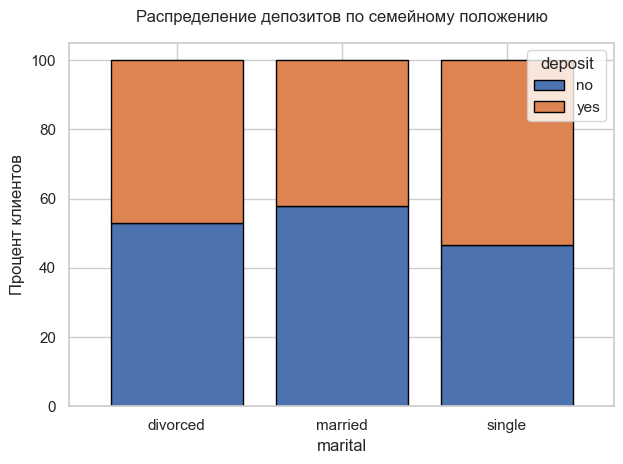

In [336]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# 1. Семейное положение
plt.figure(figsize=(10, 5))
marital_data = df.groupby(['marital', 'deposit']).size().unstack()
(marital_data.div(marital_data.sum(axis=1), axis=0)*100).plot(
    kind='bar',
    stacked=True,
    edgecolor='black',
    width=0.8
)
plt.title('Распределение депозитов по семейному положению', pad=15)
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

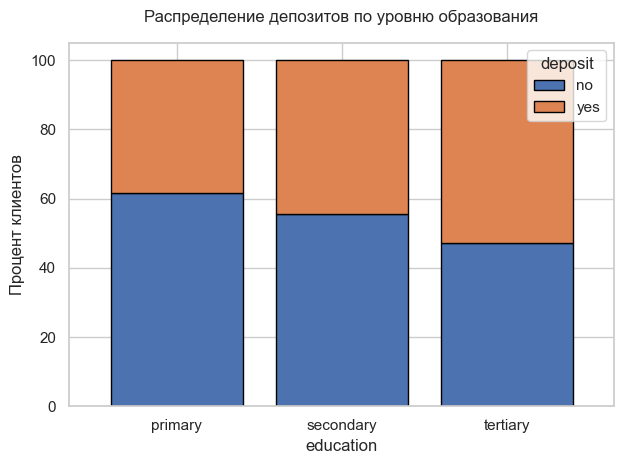

In [337]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# 2. Уровень образования
plt.figure(figsize=(10, 5))
education_order = ['primary', 'secondary', 'tertiary']
education_data = df.groupby(['education', 'deposit']).size().unstack()
(education_data.div(education_data.sum(axis=1), axis=0)*100).loc[education_order].plot(
    kind='bar',
    stacked=True,
    edgecolor='black',
    width=0.8
)
plt.title('Распределение депозитов по уровню образования', pad=15)
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

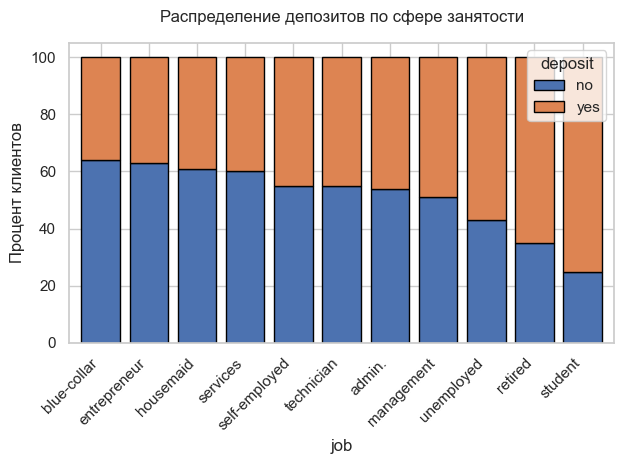

In [338]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# 3. Сфера занятости
plt.figure(figsize=(12, 6))
job_data = df.groupby(['job', 'deposit']).size().unstack()
(job_data.div(job_data.sum(axis=1), axis=0)*100).sort_values('yes').plot(
    kind='bar',
    stacked=True,
    edgecolor='black',
    width=0.8
)
plt.title('Распределение депозитов по сфере занятости', pad=15)
plt.ylabel('Процент клиентов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Задание 11

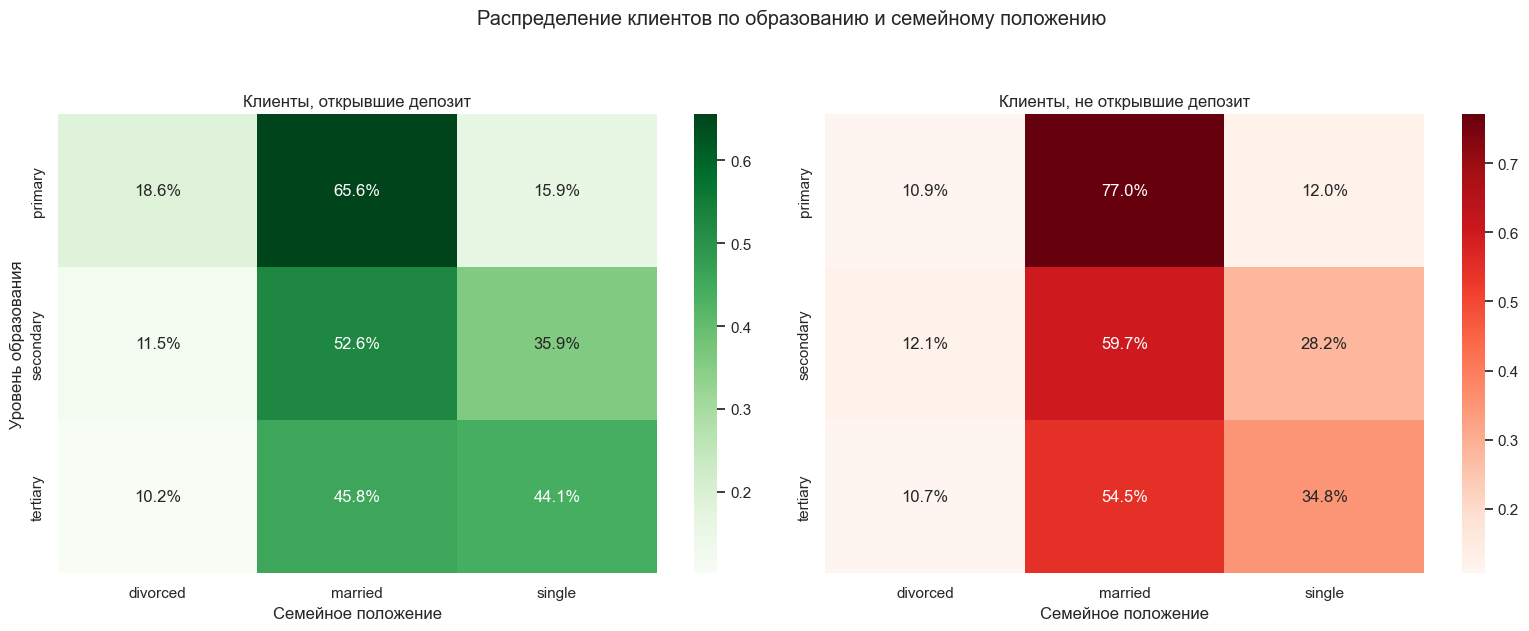

In [339]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Создаем подгруппы
depositors = df[df['deposit'] == 'yes']
non_depositors = df[df['deposit'] == 'no']

# Настройка графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Распределение клиентов по образованию и семейному положению', y=1.05)

# Тепловая карта для открывших депозит
pivot_dep = pd.crosstab(depositors['education'], depositors['marital'], normalize='index')
sns.heatmap(pivot_dep, annot=True, fmt='.1%', cmap='Greens', ax=ax1)
ax1.set_title('Клиенты, открывшие депозит')
ax1.set_xlabel('Семейное положение')
ax1.set_ylabel('Уровень образования')

# Тепловая карта для не открывших депозит
pivot_non = pd.crosstab(non_depositors['education'], non_depositors['marital'], normalize='index')
sns.heatmap(pivot_non, annot=True, fmt='.1%', cmap='Reds', ax=ax2)
ax2.set_title('Клиенты, не открывшие депозит')
ax2.set_xlabel('Семейное положение')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [340]:
# преобразуйте уровни образования
# Инициализируем LabelEncoder
le = LabelEncoder()

# Применяем кодировку к признаку education
df['education_encoded'] = le.fit_transform(df['education'])

# Проверяем соответствие кодов исходным значениям
print('Соответствие кода исходным данным:')
for i, category in enumerate(le.classes_):
    print(f'{category} : {i}')
    
# Выводим первые 5 строк для проверки
print('\n Первые 5 строк после кодирования:')
print(df['education_encoded'].head())

Соответствие кода исходным данным:
primary : 0
secondary : 1
tertiary : 2

 Первые 5 строк после кодирования:
0    1
1    1
2    1
3    1
4    2
Name: education_encoded, dtype: int64


### Кодирование возрастных групп

In [341]:
# Упорядоченные возрастные группы
age_groups = ['<30', '30-40', '40-50', '50-60', '60+']

# Создаем кодировщик с явным указанием порядка
age_encoder = OrdinalEncoder(categories=[age_groups])

# Применяем кодирование
df['age_group_encoded'] = age_encoder.fit_transform(df[['age_group']])

# Проверяем соответствие
print("Соответствие кодов возрастным группам:")
for code, group in enumerate(age_encoder.categories_[0]):
    print(f"{group}: {code}")

Соответствие кодов возрастным группам:
<30: 0
30-40: 1
40-50: 2
50-60: 3
60+: 4


### Кодирование целевой переменной deposit

In [342]:
# Преобразуем yes->1, no->0
df['deposit_encoded'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Проверяем распределение
print("\nРаспределение целевой переменной:")
print(df['deposit_encoded'].value_counts(normalize=True))


Распределение целевой переменной:
deposit_encoded
0    0.536764
1    0.463236
Name: proportion, dtype: float64


### Задания 2 и 3

In [343]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Список бинарных переменных для преобразования
binary_cols = ['default', 'housing', 'loan']

# Преобразуем каждую переменную
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)
    
    # Проверяем преобразование
    print(f"\nРаспределение для {col}:")
    print(df[col].value_counts(normalize=True))


Распределение для default:
default
0    0.983572
1    0.016428
Name: proportion, dtype: float64

Распределение для housing:
housing
0    0.518852
1    0.481148
Name: proportion, dtype: float64

Распределение для loan:
loan
0    0.862147
1    0.137853
Name: proportion, dtype: float64


### Задание 4

In [344]:
# создайте дамми-переменные
# Список номинальных переменных для преобразования
nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаем dummy-переменные с помощью pandas.get_dummies()
dummy_df = pd.get_dummies(df[nominal_cols], drop_first=True, dtype='int')

# Объединяем с исходным DataFrame
df = pd.concat([df, dummy_df], axis=1)

# Проверим результат
print(f"Исходное количество столбцов: {len(nominal_cols)}")
print(f"Создано новых dummy-столбцов: {len(dummy_df.columns)}")
print("\nПример новых столбцов:")
print(dummy_df.columns.tolist()[:10])  # Выводим первые 10 новых столбцов

Исходное количество столбцов: 5
Создано новых dummy-столбцов: 28

Пример новых столбцов:
['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed']


### Задания 5 и 6

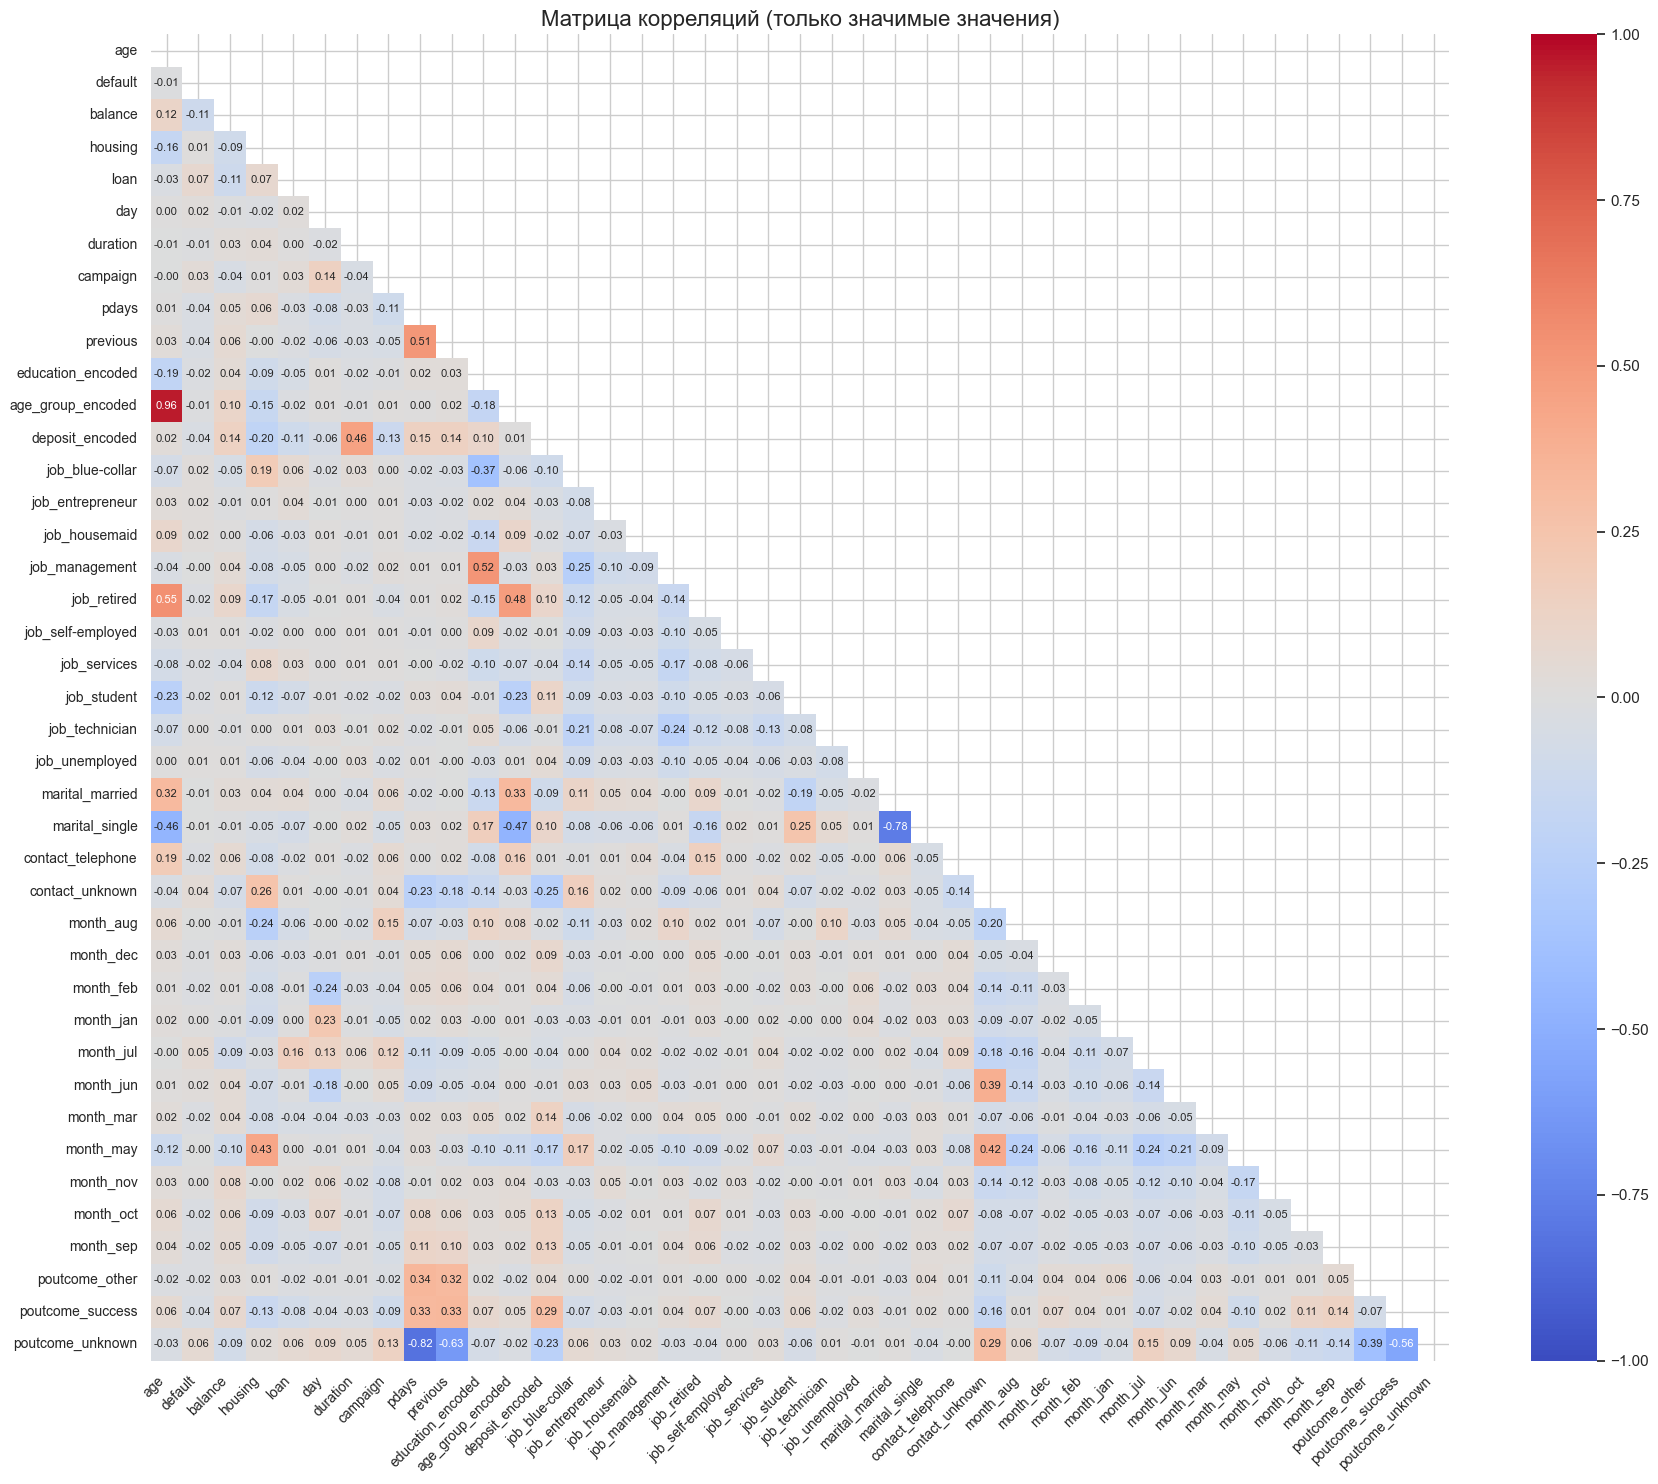

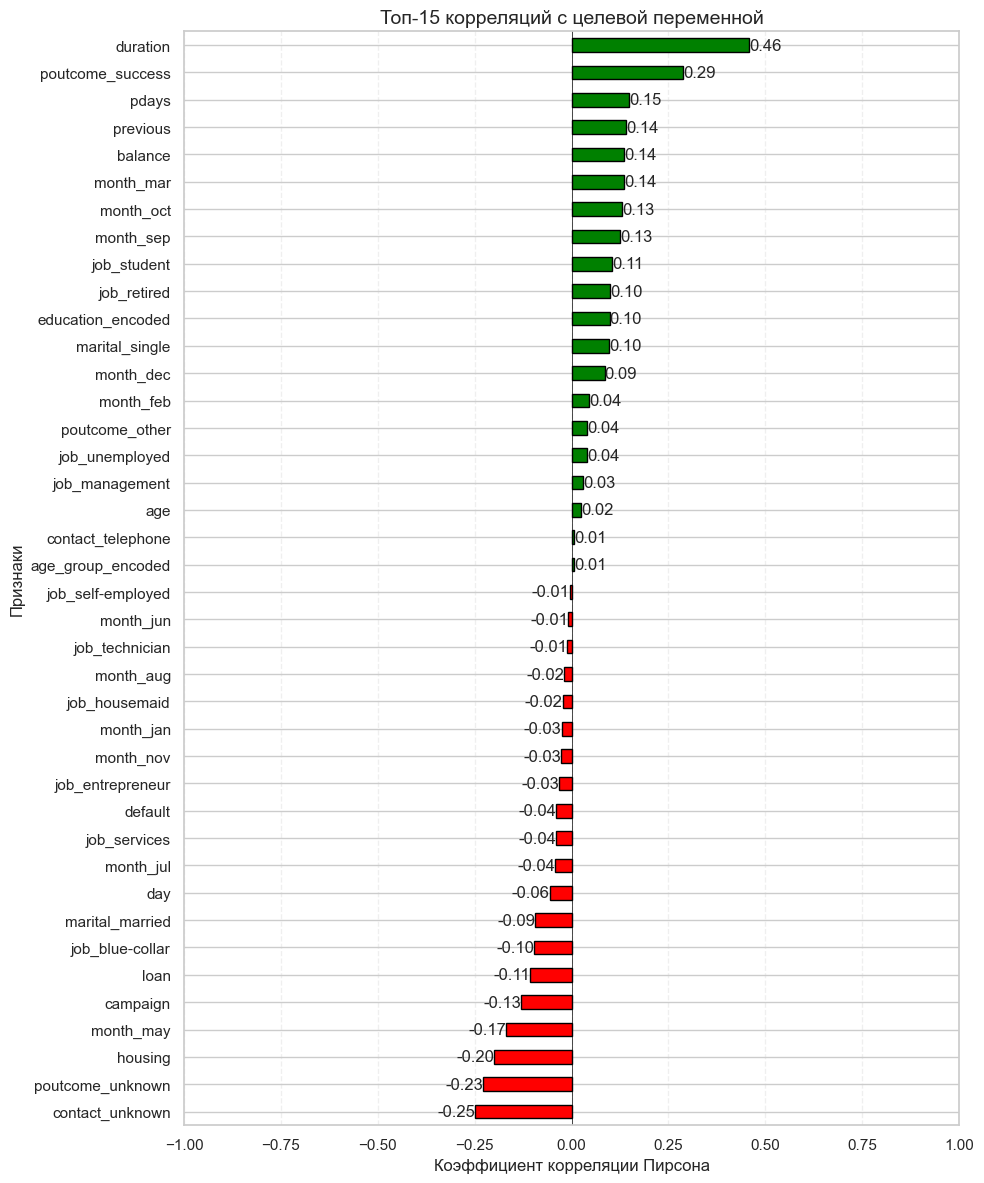

In [345]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Выбираем только числовые признаки (включая dummy-переменные)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Строим матрицу корреляций
corr_matrix = df[numeric_cols].corr()

# Тепловая карта с аннотациями для значимых значений
plt.figure(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Скрываем верхний треугольник
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            annot_kws={'size': 8})
plt.title('Матрица корреляций (только значимые значения)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Выделяем корреляции с целевой переменной
corr_with_target = corr_matrix['deposit_encoded'].drop('deposit_encoded').sort_values()

# Столбчатая диаграмма
plt.figure(figsize=(10, 12))
colors = ['green' if x >=0 else 'red' for x in corr_with_target]
corr_with_target.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Топ-15 корреляций с целевой переменной', fontsize=14)
plt.xlabel('Коэффициент корреляции Пирсона', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlim(-1, 1)

# Добавляем подписи значений
for i, v in enumerate(corr_with_target):
    plt.text(v, i, f"{v:.2f}", ha='left' if v >=0 else 'right', va='center')

plt.tight_layout()
plt.show()

### Задания 7 и 8

In [346]:
X = df.drop(['deposit_encoded'], axis=1)
y = df['deposit_encoded']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [347]:
# рассчитайте необходимые показатели
print(X_test.shape)
mean_test = y_test.mean()
print(round(mean_test, 2))

(3335, 48)
0.46


### Задание 9

In [348]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# 1. Выбираем только числовые признаки из обучающей выборки
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]

# 2. Инициализируем SelectKBest с f_classif
selector = SelectKBest(score_func=f_classif, k=15)

# 3. Применяем к обучающим и тестовым данным
X_train_selected = selector.fit_transform(X_train_numeric, y_train)
X_test_selected = selector.transform(X_test[numeric_cols])

# 4. Получаем маску выбранных признаков
selected_mask = selector.get_support()
selected_features = X_train_numeric.columns[selected_mask]

# 5. Выводим результаты
print("Отобрано 15 лучших признаков:")
print(selected_features.tolist())

Отобрано 15 лучших признаков:
['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_student', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [349]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()

# Нормализуем обучающую выборку (фит + трансформ)
X_train_normalized = scaler.fit_transform(X_train_selected)

# Нормализуем тестовую выборку (только трансформ на основе параметров из train)
X_test_normalized = scaler.transform(X_test_selected)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [350]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)

log_reg.fit(X_train_normalized, y_train)

#Предсказание на тестовой выборке
y_pred = log_reg.predict(X_test_normalized)

#Оценка качества
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


### Задания 2,3,4

In [359]:
# обучите решающие деревья, настройте максимальную глубину
#Инициализация и обучение модели
tree_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

tree_model.fit(X_train_normalized, y_train)
y_test_pred = tree_model.predict(X_test_normalized)
y_train_pred = tree_model.predict(X_train_normalized)

#Оценка качества
print('Оценка качества на тестовой выборке:\n')
print(metrics.classification_report(y_test, y_test_pred))
print('Оценка качества на тренеровочной выборке:\n')
print(metrics.classification_report(y_train, y_train_pred))

Оценка качества на тестовой выборке:

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

Оценка качества на тренеровочной выборке:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



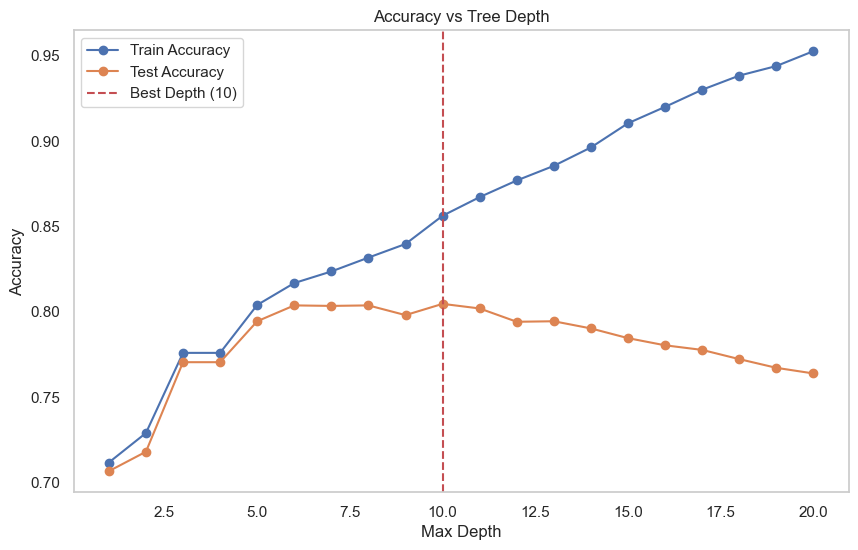

Наилучшая accuracy: 0.8
Оптимальная глубина: 10


In [362]:
# Инициализация
max_depths = range(1, 21)
train_acc = []
test_acc = []
best_acc = 0
best_depth = 1

# Перебор глубин
for depth in max_depths:
    model = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=depth,
        random_state=42
    )
    model.fit(X_train_normalized, y_train)
    
    # Расчет accuracy
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train_normalized))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test_normalized))
    
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    
    # Обновление лучшего результата
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_depth = depth

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_acc, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_acc, label='Test Accuracy', marker='o')
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Best Depth ({best_depth})')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.grid()
plt.show()

print(f"Наилучшая accuracy: {round(best_acc, 2)}")
print(f"Оптимальная глубина: {best_depth}")

### Задание 5

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}
Лучшая accuracy: 0.8
Accuracy на тестовой выборке: 0.8
F1 score на тестовой выборке: 0.78


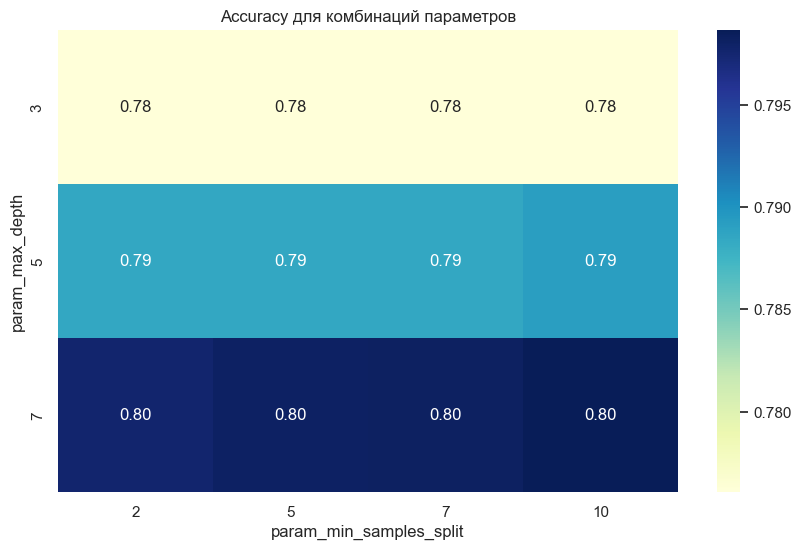

In [365]:
# подберите оптимальные параметры с помощью gridsearch
# 1. Определяем параметры для перебора
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7],
    'criterion': ['entropy']  # Фиксируем entropy по условию задачи
}

# 2. Инициализируем модель и GridSearch
tree_model = tree.DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-кратная кросс-валидация
    n_jobs=-1  # Используем все ядра процессора
)

# 3. Запускаем поиск
grid_search.fit(X_train_normalized, y_train)

# 4. Выводим результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая accuracy:", round(grid_search.best_score_, 2))

# 5. Оцениваем на тестовой выборке
best_tree = grid_search.best_estimator_
test_f1 = best_tree.score(X_test_normalized, y_test)
y_pred = best_tree.predict(X_test_normalized)
f1 = metrics.f1_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", round(test_accuracy, 2))
print('F1 score на тестовой выборке:', round(f1, 2))

# 6. Визуализация результатов
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_max_depth', 
                                columns='param_min_samples_split', 
                                values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Accuracy для комбинаций параметров")
plt.show()

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [374]:
# обучите на ваших данных случайный лес
# Инициализация модели
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Обучение модели
rf.fit(X_train_normalized, y_train)

# Предсказание на тестовой выборке
y_pred = rf.predict(X_test_normalized)
y_proba = rf.predict_proba(X_test_normalized)[:, 1]

# Оценка качества
print('Classification Report:\n', metrics.classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [375]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# 1. Инициализация и обучение Gradient Boosting
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_normalized, y_train)

# 2. Предсказание и оценка
y_pred_gb = gb.predict(X_test_normalized)
y_proba_gb = gb.predict_proba(X_test_normalized)[:, 1]

print("Gradient Boosting Classification Report:")
print(metrics.classification_report(y_test, y_pred_gb))

# 3. Сравнение с Random Forest
print("\nСравнение моделей:")
print(f"{'Metric':<15} | {'Random Forest':<15} | {'Gradient Boosting':<15}")
print("-" * 50)
print(f"{'Accuracy':<15} | {metrics.accuracy_score(y_test, y_pred):.2f}          | {metrics.accuracy_score(y_test, y_pred_gb):.2f}")
print(f"{'F1-score':<15} | {metrics.f1_score(y_test, y_pred):.2f}          | {metrics.f1_score(y_test, y_pred_gb):.2f}")
print(f"{'ROC-AUC':<15} | {metrics.roc_auc_score(y_test, y_proba):.2f}          | {metrics.roc_auc_score(y_test, y_proba_gb):.2f}")

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335


Сравнение моделей:
Metric          | Random Forest   | Gradient Boosting
--------------------------------------------------
Accuracy        | 0.83          | 0.83
F1-score        | 0.82          | 0.82
ROC-AUC         | 0.90          | 0.90


### Задание 4

In [377]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# 1. Определяем базовые модели
base_models = [
    ('decision_tree', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_leaf=5,
        random_state=42
    )),
    ('logistic_regression', linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
    )),
    ('gradient_boosting', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# 2. Инициализируем стекинг-ансамбль
stacking_model = ensemble.StackingClassifier(
    estimators=base_models,
    final_estimator=linear_model.LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# 3. Обучение ансамбля
stacking_model.fit(X_train_normalized, y_train)

# 4. Оценка качества
y_pred_stack = stacking_model.predict(X_test_normalized)

print("Stacking Ensemble Classification Report:")
print(metrics.classification_report(y_test, y_pred_stack))

Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

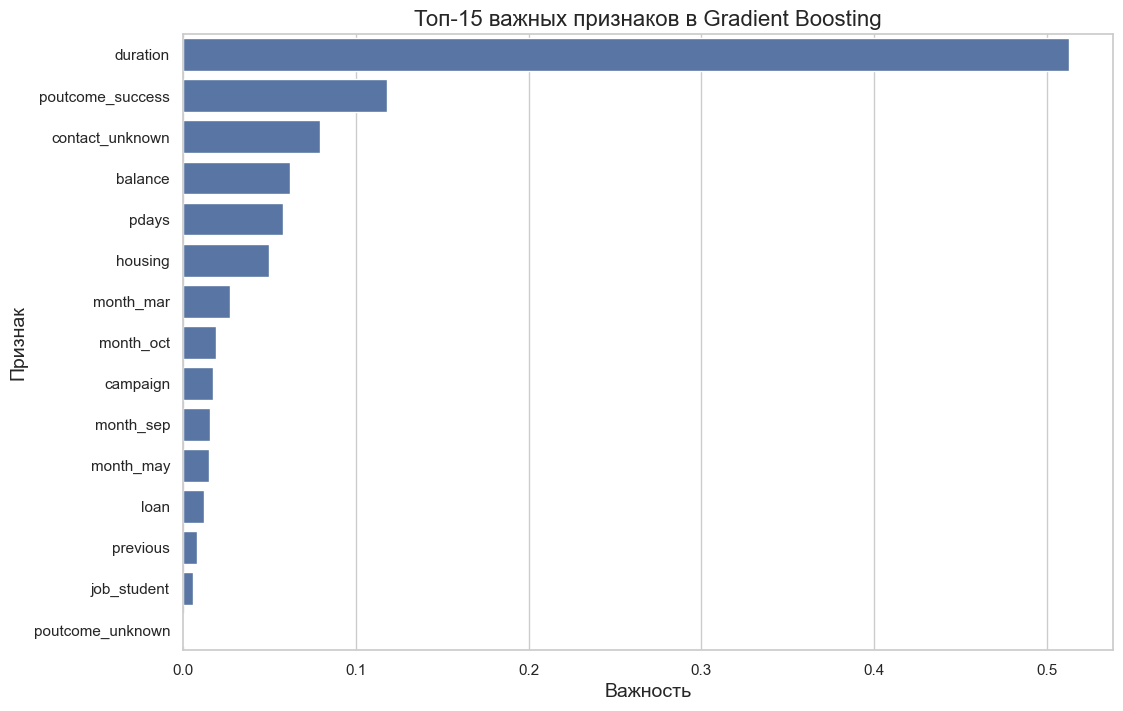

         Feature  Importance
        duration    0.512996
poutcome_success    0.117808
 contact_unknown    0.079413
         balance    0.061744
           pdays    0.057966
         housing    0.049387
       month_mar    0.027306
       month_oct    0.018960
        campaign    0.017227
       month_sep    0.015689
       month_may    0.014792
            loan    0.012288
        previous    0.008129
     job_student    0.005803
poutcome_unknown    0.000491


In [379]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Получаем важность признаков
feature_importance = gb.feature_importances_

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': selected_features,  # Используем ранее отобранные признаки
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Визуализация топ-15 важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Топ-15 важных признаков в Gradient Boosting', fontsize=16)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.show()

# Вывод таблицы с важностью
print(importance_df.head(15).to_string(index=False))

### Задания 6,7,8

In [389]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def objective(trial):
    # 1. Определяем пространство поиска параметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
        'criterion': 'gini',
        'random_state': 42,
        'n_jobs': -1
    }
    
    # 2. Инициализируем и обучаем модель
    model = ensemble.RandomForestClassifier(**params)
    model.fit(X_train_normalized, y_train)
    
    # 3. Оцениваем качество на валидационной выборке
    y_pred = model.predict(X_test_normalized)
    return metrics.f1_score(y_test, y_pred)

# 4. Создаем study и запускаем оптимизацию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Количество итераций

# 5. Выводим результаты
print("Лучшие параметры:", study.best_params)
print("Лучший F1-score:", round(study.best_value, 2))

# 6. Визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

# Обучаем финальную модель с лучшими параметрами
best_rf = ensemble.RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_normalized, y_train)

# Оценка на тестовой выборке
y_pred = best_rf.predict(X_test_normalized)
f1 = metrics.f1_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("\nОценка на тестовой выборке:")
print(f"F1-score: {round(f1, 2)}")
print(f"Accuracy: {round(accuracy, 2)}")

[I 2025-07-06 00:26:58,655] A new study created in memory with name: no-name-9fca9a8d-a9f2-45af-ab8d-88f73626ec7f
[I 2025-07-06 00:26:59,105] Trial 0 finished with value: 0.823195713835487 and parameters: {'n_estimators': 114, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.823195713835487.
[I 2025-07-06 00:26:59,779] Trial 1 finished with value: 0.8205938092229943 and parameters: {'n_estimators': 183, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.823195713835487.
[I 2025-07-06 00:27:00,237] Trial 2 finished with value: 0.8158640226628895 and parameters: {'n_estimators': 118, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.823195713835487.
[I 2025-07-06 00:27:00,876] Trial 3 finished with value: 0.8168567807351077 and parameters: {'n_estimators': 169, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.823195713835487.
[I 2025-07-06 00:27:01,289] Trial 4 finished with value: 0.8169996828417381 an

Лучшие параметры: {'n_estimators': 196, 'max_depth': 12, 'min_samples_leaf': 4}
Лучший F1-score: 0.83



Оценка на тестовой выборке:
F1-score: 0.83
Accuracy: 0.83
